---

# Obiective 2: Investigate the relationship between traffic and emissions using machine learning

**Dong Liang** (1399853), **Pamungkas Intan** (1280937)

1. Acquire data of the same time range.

2. Assemble a dataset with traffic performance data and emission data.

3. Preprocess the data and prepare the data for model fitting.

4. Use training and test sets for model training and evaluation.

5. Compare the three linear regression models used and find the best model for prediction.

6. Predict the emission from road transport for the next three year.

## Load libraries

In [1]:
# Load libraries
import os
from os.path import exists
import requests
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

## Creating directory for data

In [2]:
# Creating folders to storage datasets
directory = "datasets"

parent_dir = os.getcwd()

data_path = parent_dir + directory

path = os.path.join(parent_dir, directory)

if not exists(path):
    os.mkdir(path)

print(f"Directory {directory} created")

Directory datasets created


## Download data

We download the preprocessed data from our github project because the original data is split by year and by province in the data source website.

Traffic performance data includes number of transactions and vehicles from National Toll Collection System.
Emission data includes emission of road transport, such as NOX, PM2.5 and CH4.

Data sources:

https://transtat.stat.gov.pl/2-3/2-3-7.aspx

https://transtat.stat.gov.pl/2-3/2-3-4.aspx

https://transtat.stat.gov.pl/2-3/2-3-5.aspx

https://transtat.stat.gov.pl/2-3/2-3-3.aspx

https://transtat.stat.gov.pl/2-1/2-1-4.aspx

https://transtat.stat.gov.pl/2-1/2-1-14.aspx

N2O emission:

In [3]:
if not exists(path + 'Indicator 2-3-7 - N2O emission by vehicle type.csv'):
    url = "https://raw.githubusercontent.com/hudsonpassos85/DSSE/main/Raw%20Data/Indicator%202-3-7%20-%20N2O%20emission%20by%20vehicle%20type.csv"
    response = requests.get(url, stream=True)
    with open(path + '\\' + 'Indicator 2-3-7 - N2O emission by vehicle type.csv', "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

NOx emission:

In [4]:
if not exists(path + 'Indicator 2-3-4 - NOx emission by vehicle type.csv'):
    url = "https://raw.githubusercontent.com/hudsonpassos85/DSSE/main/Raw%20Data/Indicator%202-3-4%20-%20NOx%20emission%20by%20vehicle%20type.csv"
    response = requests.get(url, stream=True)
    with open(path + '\\' + 'Indicator 2-3-4 - NOx emission by vehicle type.csv', "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

CH4 emission:

In [5]:
if not exists(path + 'Indicator 2-3-5 - CH4 emission by vehicle type.csv'):
    url = "https://raw.githubusercontent.com/hudsonpassos85/DSSE/main/Raw%20Data/Indicator%202-3-5%20-%20CH4%20emission%20by%20vehicle%20type.csv"
    response = requests.get(url, stream=True)
    with open(path + '\\' + 'Indicator 2-3-5 - CH4 emission by vehicle type.csv', "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

PM2.5 emission:

In [6]:
if not exists(path + 'Indicator 2-3-3 - PM2.5 emission by vehicle type.csv'):
    url = "https://raw.githubusercontent.com/hudsonpassos85/DSSE/main/Raw%20Data/Indicator%202-3-3%20-%20PM2.5%20emission%20by%20vehicle%20type.csv"
    response = requests.get(url, stream=True)
    with open(path + '\\' + 'Indicator 2-3-3 - PM2.5 emission by vehicle type.csv', "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

Number of transactions (monthly):

From National Toll Collection System and National Revenue Administration Electronic Toll Collection System

In [7]:
if not exists(path + 'Indicator 2-1-4 - Number of transactions (monthly) by vehicle type.csv'):
    url = "https://raw.githubusercontent.com/hudsonpassos85/DSSE/main/Raw%20Data/Indicator%202-1-4%20-%20Number%20of%20transactions%20(monthly)%20by%20vehicle%20type.csv"
    response = requests.get(url, stream=True)
    with open(path + '\\' + 'Indicator 2-1-4 - Number of transactions (monthly) by vehicle type.csv', "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

Number of vehicles (monthly):

From National Toll Collection System and National Revenue Administration Electronic Toll Collection System

In [8]:
if not exists(path + 'Indicator 2-1-14 - Number of vehicles (monthly) by vehicle type.csv'):
    url = "https://raw.githubusercontent.com/hudsonpassos85/DSSE/main/Raw%20Data/Indicator%202-1-14%20-%20Number%20of%20vehicles%20(monthly)%20by%20vehicle%20type.csv"
    response = requests.get(url, stream=True)
    with open(path + '\\' + 'Indicator 2-1-14 - Number of vehicles (monthly) by vehicle type.csv', "wb") as f:
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

## Preprocess datasets

In [9]:
# Read datasets
n2o_emission = pd.read_csv(path + '\\' + 'Indicator 2-3-7 - N2O emission by vehicle type.csv')
nox_emission = pd.read_csv(path + '\\' + 'Indicator 2-3-4 - NOx emission by vehicle type.csv')
ch4_emission = pd.read_csv(path + '\\' + 'Indicator 2-3-5 - CH4 emission by vehicle type.csv')
pm25_emission = pd.read_csv(path + '\\' + 'Indicator 2-3-3 - PM2.5 emission by vehicle type.csv')
transactions = pd.read_csv(path + '\\' + 'Indicator 2-1-4 - Number of transactions (monthly) by vehicle type.csv')
vehicles = pd.read_csv(path + '\\' + 'Indicator 2-1-14 - Number of vehicles (monthly) by vehicle type.csv')

In [10]:
# Preprocess emission datasets
n2o_emission = n2o_emission.sort_values(by = ['Year','Quarter'], ignore_index = True)
nox_emission = nox_emission.sort_values(by = ['Year','Quarter'], ignore_index = True)
ch4_emission = ch4_emission.sort_values(by = ['Year','Quarter'], ignore_index = True)
pm25_emission = pm25_emission.sort_values(by = ['Year','Quarter'], ignore_index = True)

# Merge the emission data into a single dataset
emission = pd.DataFrame()
emission['n2o'] = n2o_emission['Total']
emission['nox'] = nox_emission['Total']
emission['ch4'] = ch4_emission['Total']
emission['pm2.5'] = pm25_emission['Total']

In [11]:
# Unify time scale to quarter
transactions['date'] = pd.to_datetime(transactions['Month']+' '+transactions['Year'].astype(str), format='%B %Y')
transactions.index = transactions['date']
transactions = transactions.drop('date',axis=1)
transactions_quarterly = transactions.resample('Q').sum()
transactions_quarterly['Year'] = transactions_quarterly.index.year
transactions_quarterly['Quarter'] = transactions_quarterly.index.quarter
transactions_quarterly = transactions_quarterly.reset_index()

vehicles['date'] = pd.to_datetime(vehicles['Month']+' '+vehicles['Year'].astype(str), format='%B %Y')
vehicles.index = vehicles['date']
vehicles = vehicles.drop('date',axis=1)
vehicles_quarterly = vehicles.resample('Q').sum()
vehicles_quarterly['Year'] = vehicles_quarterly.index.year
vehicles_quarterly['Quarter'] = vehicles_quarterly.index.quarter
vehicles_quarterly = vehicles_quarterly.reset_index()

In [12]:
# Sum different types vehicles
transactions_quarterly['total_transactions'] = transactions_quarterly.iloc[:,3:7].sum(axis = 1)

vehicles_quarterly['total_vehicles'] = vehicles_quarterly.iloc[:,3:7].sum(axis = 1)

In [13]:
# Prepare training and test data
x = transactions_quarterly[['total_transactions']].merge(vehicles_quarterly[['total_vehicles']],
                                                         left_index=True,
                                                         right_index=True
                                                        ).iloc[0:16,:]

In [14]:
# Create train and test sets
y = emission

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=32)

## Visualize the trend of traffic and emission

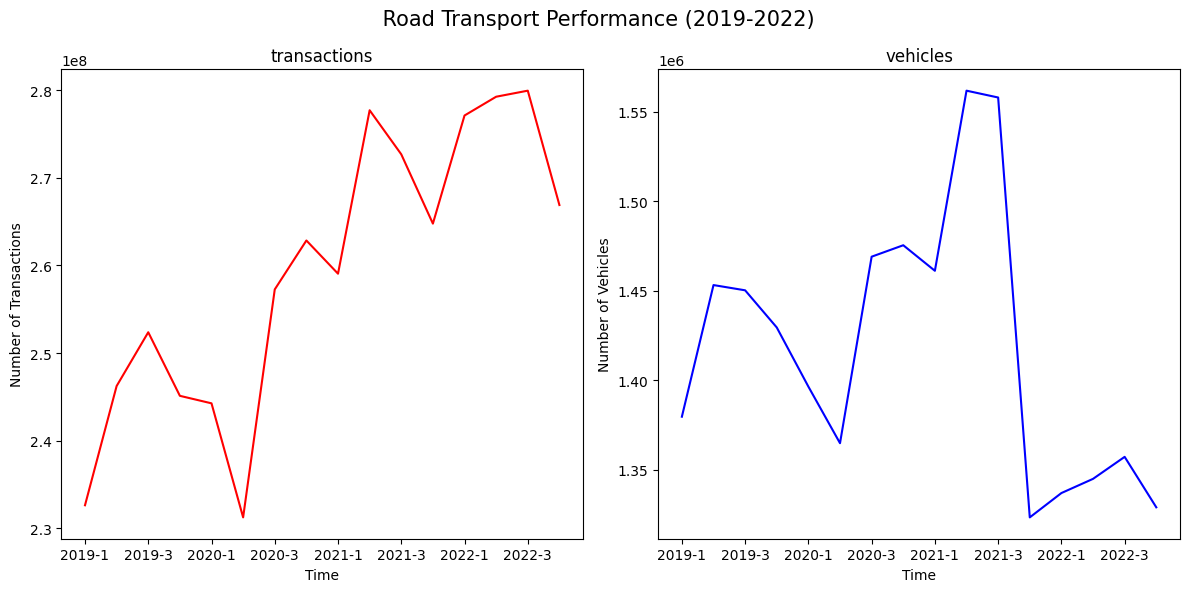

In [15]:
# Create a 1*2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Set data with subplots and plot
axs[0].plot(x.iloc[: , 0], label='transactions',color='red')
axs[1].plot(x.iloc[: , 1], label='vehicles',color='blue')

# Set a main title for all the subplots
fig.suptitle(' Road Transport Performance (2019-2022)', fontsize=15)

# Add labels for axes
for ax in axs:
    ax.set_xlabel('Time',fontsize=10)

axs[0].set_ylabel('Number of Transactions',fontsize=10)
axs[1].set_ylabel("Number of Vehicles",fontsize=10)

plt.setp(axs, xticks=[0, 2, 4, 6, 8, 10, 12, 14], xticklabels=['2019-1', '2019-3', '2020-1', '2020-3', '2021-1', '2021-3', '2022-1', '2022-3'])

# Set the title to subplots
axs[0].set_title("transactions",fontsize=12)
axs[1].set_title("vehicles",fontsize=12)

# Set spacing
fig.tight_layout()
plt.show()

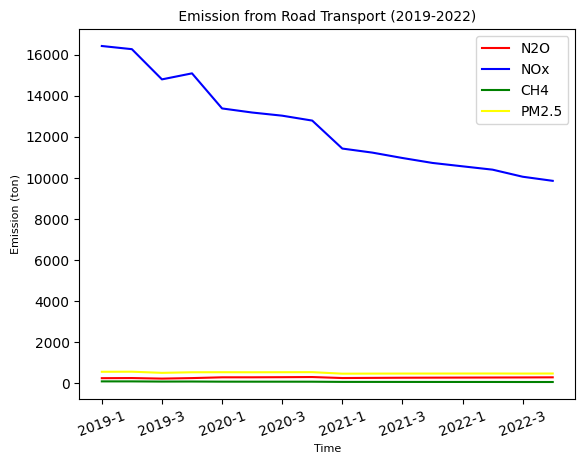

In [16]:
# Plot the data of emission

plt.plot(emission['n2o'], label='N2O',color='red')
plt.plot(emission['nox'], label='NOx',color='blue')
plt.plot(emission['ch4'], label='CH4',color='green')
plt.plot(emission['pm2.5'], label='PM2.5',color='yellow')

plt.legend()

plt.xlabel('Time',fontsize=8)
plt.ylabel('Emission (ton)',fontsize=8)

# Set a main title
plt.title(' Emission from Road Transport (2019-2022) ', fontsize=10)

plt.xticks([0, 2, 4, 6, 8, 10, 12, 14], ['2019-1', '2019-3', '2020-1', '2020-3', '2021-1', '2021-3', '2022-1', '2022-3'], rotation=20)
plt.show()

## Random Forest Regression

**The reason why I choose this model:**

Random Forest is an ensemble learning method that combines the predictions of multiple decision trees.

Advantages:

- Handles non-linear relationships well.
- Robust to outliers.
- Requires minimal data preprocessing (like scaling).
- Automatically handles feature importance.
- Less prone to overfitting compared to a single decision tree.

In [17]:
# Fitting Random Forest Regression to the dataset
RFregressor = MultiOutputRegressor(RandomForestRegressor(random_state=500))

In [18]:
# Fit the regressor with x and y data
RFregressor.fit(x_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=500))

In [19]:
# Make the prediction
y_pred = RFregressor.predict(x_test)

In [20]:
# Evaluate the model
mse_RF = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_RF}')

r2_RF = r2_score(y_test, y_pred)
print(f'R-squared: {r2_RF}')

Mean Squared Error: 438904.8219667969
R-squared: 0.4412701690718347


## Support Vector Regression

**The reason why I choose this model:**

LinearSVR is a linear regression model that uses Support Vector Machine principles for regression tasks. It is suitable when there is a linear relationship between the input features and the target variable.

In [21]:
# Create the SVR model
SVRregressor = MultiOutputRegressor(LinearSVR(random_state=500))

In [22]:
# Train the model on the data
SVRregressor.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearSVR(random_state=500))

In [23]:
# Make predictions on the data
y_pred = SVRregressor.predict(x_test)

In [24]:
# Evaluate the model
mse_SVR = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_SVR}')

r2_SVR = r2_score(y_test, y_pred)
print(f'R-squared: {r2_SVR}')

Mean Squared Error: 39477647.71463582
R-squared: -139.28346233627212


## Multiple Linear Regression

**The reason why I choose this model:**

Multiple Linear Regression is easier to interpret compared to the other models

Advantages:

- Provides insight into the relationship between each independent variable and the dependent variable.
- Interpretable coefficients for each feature.
- Easy to implement and computationally efficient for small to moderately sized datasets.

In [25]:
# Create a linear regression model
LinearRegressor = MultiOutputRegressor(LinearRegression())

In [26]:
# Fit the model
LinearRegressor.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [27]:
# Make predictions
y_pred = LinearRegressor.predict(x_test)

In [28]:
# Evaluate the model
mse_Linear = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_Linear}')

r2_Linear = r2_score(y_test, y_pred)
print(f'R-squared: {r2_Linear}')

Mean Squared Error: 188641.41005873526
R-squared: 0.7248884565462297


## Model Evaluation and Discussion

### Discussion on the negative R-squared


We get a negative value for the R-squared in Support Vector Regression. A negative R-squared usually indicates that the model used is not a good fit for the data, because the model can be arbitrarily worse, as is described in the documentation of scikit-learn. There are several possible causes for this problem:
1. There could be over-fitting in our model. It can be caused by various reasons like small dataset and noise in the dataset. Our dataset is indeed small, so this can be the main reason.
2. R-squared is for least squares regression and not usually for SVR. R-squared is not commonly used to evaluate the SVR model. Metrics such as Mean Squared Error (MSE) or Mean Absolute Error (MAE) are more typical for assessing the accuracy of predictions in SVR.

*From https://www.researchgate.net/post/R-Square_value_is_negative_using_SVR_in_Python#:~:text=Dear%20Abdur%20Rasheed%20%2C-,R2%20is%20negative%20only%20when%20the%20chosen%20model%20does%20not,performance%20because%20of%20over%2Dfittual

### Comparing models

After comparing these three models, we found that the multiple linear regression model has the highest R-squared in the range of (0,1). A higher R-squared value generally indicates a better fit of the model to the data.

The R-squared is not applicable for evaluating Support Vector Regression model, so it is necessary to campare the models again using MSE.

Multiple linear regression model also gets the lowest Mean Squared Error. A lower MSE indicates better predictive performance, as it means that, on average, the model's predictions are closer to the actual values.

## Predict emission from road traffic in 2023

We have access to the traffic data in Poland until 2023, but there is no traffic emission record in Poland for 2023. So, we decide to predict the emission from road traffic in 2023.

In [29]:
# Prepare the prediction data
x_pred = transactions_quarterly[['total_transactions']].merge(vehicles_quarterly[['total_vehicles']],
                                                         left_index=True,
                                                         right_index=True
                                                        ).iloc[16:,:]

In [30]:
# Make predictions
y_pred = LinearRegressor.predict(x_pred)

In [31]:
# Convert numpy array into dataframe column
y_pred = pd.DataFrame(y_pred, columns=emission.columns)

y_pred

,n2o,nox,ch4,pm2.5
0,281.567660,12032.891475,71.627795,508.001435
1,281.170219,11927.523508,71.068873,505.445227
2,282.229452,11531.493777,69.159096,498.864556
3,281.036044,11840.270227,70.620621,503.559602


In [32]:
# Add the predicted emission to the previous emission data
for i in range(4):
    emission_5years = pd.concat([emission, y_pred], ignore_index=True)

In [33]:
# Add year and quarter columns
emission_5years = pd.merge(transactions_quarterly[['Year','Quarter']], emission_5years, left_index=True, right_index=True)

emission_5years['Time'] = emission_5years['Year'].astype(str) + '-' + emission_5years['Quarter'].astype(str)

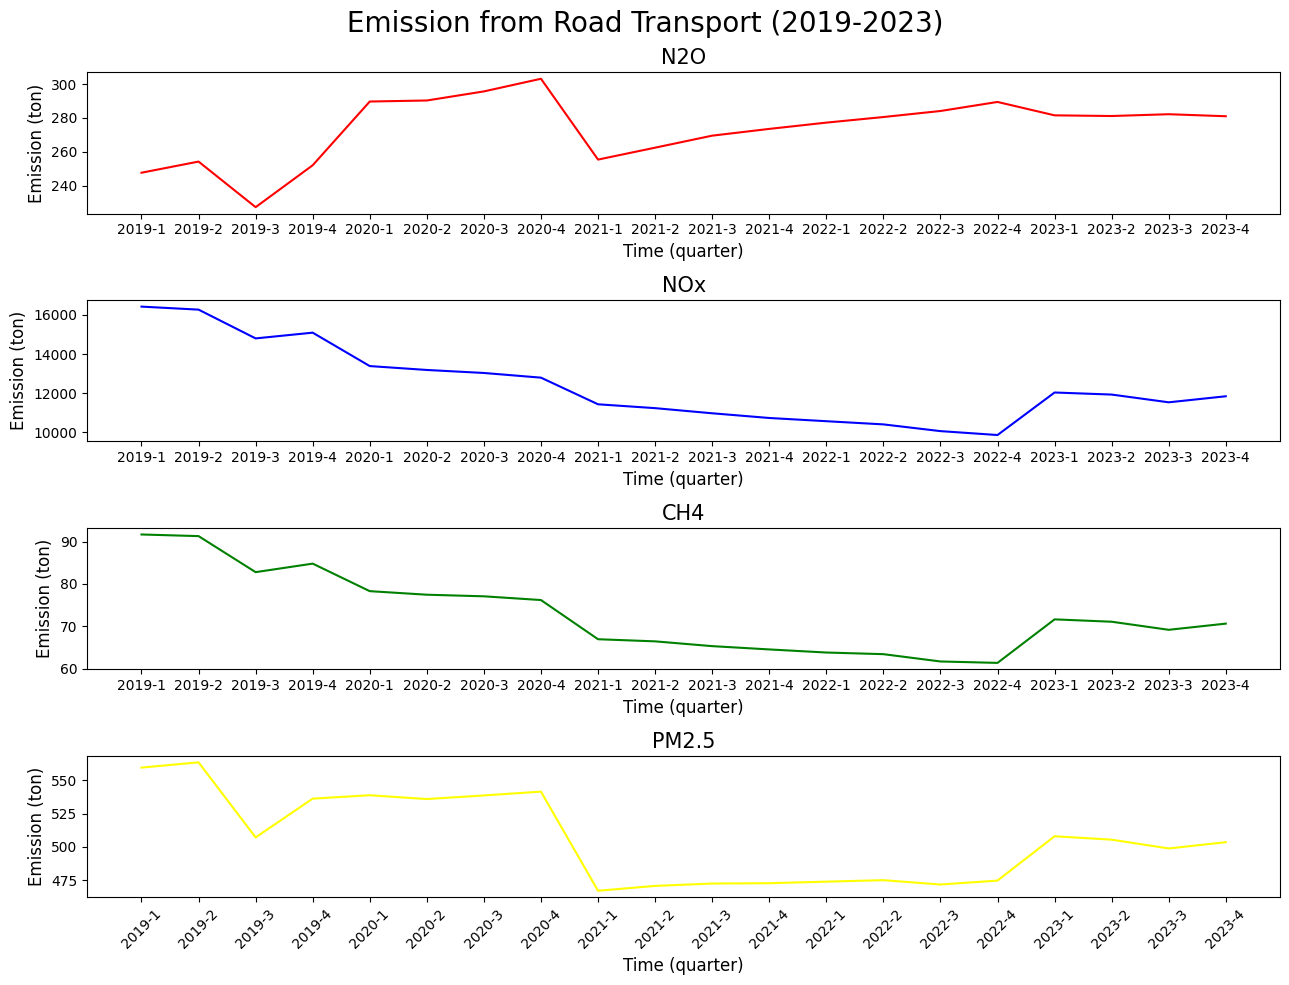

In [34]:
# Create a 4*1 grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(13, 10))

# Set data with subplots and plot
axs[0].plot(emission_5years['Time'], emission_5years['n2o'], color='red' )
axs[1].plot(emission_5years['Time'], emission_5years['nox'],color='blue')
axs[2].plot(emission_5years['Time'], emission_5years['ch4'],color='green')
axs[3].plot(emission_5years['Time'], emission_5years['pm2.5'],color='yellow')

# Set the title to subplots
axs[0].set_title("N2O",fontsize=15)
axs[1].set_title("NOx",fontsize=15)
axs[2].set_title("CH4",fontsize=15)
axs[3].set_title("PM2.5",fontsize=15)


# Set a main title for all the subplots
fig.suptitle(' Emission from Road Transport (2019-2023) ', fontsize=20)

# Add labels for axes
for ax in axs:
    ax.set_xlabel('Time (quarter)',fontsize=12)
    ax.set_ylabel('Emission (ton)',fontsize=12)

plt.xticks(rotation=45)

# Set spacing
fig.tight_layout()
plt.show()